# Welcome to Computer Vision! #

Have you ever wanted to teach a computer to see? In this course, that's exactly what you'll do!

In this course, you'll:
- Use modern deep-learning networks to build an **image classifier** with Keras
- Design your own **custom convnet** with reusable blocks
- Learn the fundamental ideas behind visual **feature extraction**
- Master the art of **transfer learning** to boost your models
- Utilize **data augmentation** to extend your dataset

If you've taken the *Introduction to Deep Learning* course, you'll know everything you need to be successful.

Now let's get started!

# Introduction #

This course will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation that gives the layers of a convnet their unique structure. In future lessons, you'll learn why this structure is so effective at solving computer vision problems.

We will apply these ideas to the problem of **image classification**: given a picture, can we train a computer to tell us what it's a picture *of*? You may have seen [apps](https://identify.plantnet.org/) that can identify a species of plant from a photograph. That's an image classifier! In this course, you'll learn how to build image classifiers just as powerful as those used in professional applications.

While our focus will be on image classification, what you'll learn in this course is relevant to every kind of computer vision problem. At the end, you'll be ready to move on to more advanced applications like generative adversarial networks and image segmentation.

# The Convolutional Classifier #

A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.

<center>
<!-- <img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">-->
<img src="https://i.imgur.com/U0n5xjU.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">
</center>

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

The whole process goes something like this:

<center>
<!-- <img src="./images/1-extract-classify.png" width="600" alt="The idea of feature extraction."> -->
<img src="https://i.imgur.com/UUAafkn.png" width="600" alt="The idea of feature extraction.">
</center>

The features actually extracted look a bit different, but it gives the idea.

# Training the Classifier #

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**. To the pretrained base we then **attach an untrained head**. In other words, we reuse the part of a network that has already learned to do *1. Extract features*, and attach to it some fresh layers to learn *2. Classify*.

<center>
<!-- <img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base."> -->
<img src="https://imgur.com/E49fsmV.png" width="400" alt="Attaching a new head to a trained base.">
</center>

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data. 

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

# Example - Train a Convnet Classifier #

Throughout this course, we're going to be creating classifiers that attempt to solve the following problem: is this a picture of a *Car* or of a *Truck*? Our dataset is about 10,000 pictures of various automobiles, around half cars and half trucks.

## Step 1 - Load Data ##

This next hidden cell will import some libraries and set up our data pipeline. We have a training split called `ds_train` and a validation split called `ds_valid`.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


Let's take a look at a few examples from the training set.

In [2]:

import matplotlib.pyplot as plt

## Step 2 - Define Pretrained Base ##

The most commonly used dataset for pretraining is [*ImageNet*](http://image-net.org/about-overview), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [`applications` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications). The pretrained model we'll use is called **VGG16**.

In [3]:
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

## Step 3 - Attach Head ##

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score for class 1, `Truck`. The `Flatten` layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 4 - Train ##

Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of `crossentropy` and `accuracy`. The `adam` optimizer generally performs well, so we'll choose it as well.

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

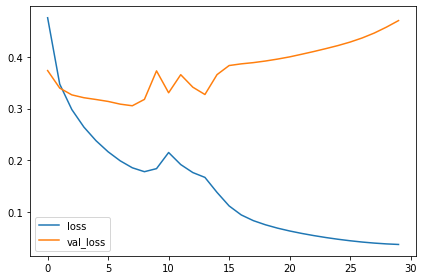

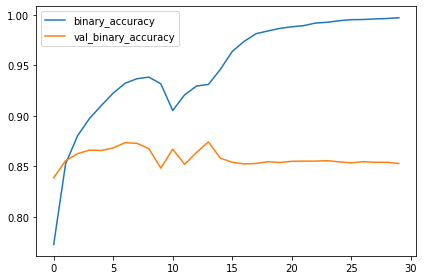

In [6]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# Conclusion #

In this lesson, we learned about the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind convolutional classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

For the next few lessons, we'll take a look at how the convolutional base accomplishes the feature extraction. Then, you'll learn how to apply these ideas and design some classifiers of your own.

# Your Turn #

For now, move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/10781907) and build your own image classifier!

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/196537) to chat with other Learners.*